# <center> Predicting the Success of a Kickstarter Campaign: Sharon Agai </center>

## Choosing a Dataset

https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv <br>
I used the second data source provided, ks-projects-2018-01. 

## Initial thoughts
- Classification vs. clustering - we have a large training dataset, so a supervised learning-based approached such as classification should work well
- Classification algorithm candidates: logistic regression, K-NN, SVM, Naive Bayes, Decision Tree, Random Forest 

## Preprocessing
### Preprocessing - data cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
data = pd.read_csv("ks-projects-201801.csv")
data.columns = data.columns.str.replace(' ', '_')
data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd_pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [3]:
print("Unique project states: ", data['state'].unique())
print("Unique main categories: ", data['main_category'].unique())
print("Unique categories: ", data['category'].unique())
print("Unique countries: ", data['country'].unique())

Unique project states:  ['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
Unique main categories:  ['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']
Unique categories:  ['Poetry' 'Narrative Film' 'Music' 'Film & Video' 'Restaurants' 'Food'
 'Drinks' 'Product Design' 'Documentary' 'Nonfiction' 'Indie Rock'
 'Crafts' 'Games' 'Tabletop Games' 'Design' 'Comic Books' 'Art Books'
 'Fashion' 'Childrenswear' 'Theater' 'Comics' 'DIY' 'Webseries'
 'Animation' 'Food Trucks' 'Public Art' 'Illustration' 'Photography' 'Pop'
 'People' 'Art' 'Family' 'Fiction' 'Accessories' 'Rock' 'Hardware'
 'Software' 'Weaving' 'Gadgets' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals'
 'Video Games' 'Anthologies' 'Publishing' 'Shorts' 'Electronic Music'
 'Radio & Podcasts' 'Apps' 'Cookbooks' 'Apparel' 'Metal' 'Comedy'
 'Hip-Hop' 'Periodicals' 'Dance' 'Technology' 'Painting' 'World Music'
 'Photobooks' '

There are 6 possible project states - successful, failed, canceled, live, undefined, and suspended. Since we are trying to predict success and failure, I will extract those only. 

In [4]:
# Fixing a small entry error
data.country = data.country.replace(to_replace='N,0"', value='NO')

In [5]:
successdata = data[data.state == 'successful']
faildata = data[data.state == 'failed']
alldata = pd.concat([successdata, faildata])
print(alldata.head())

            ID                                               name  \
5   1000014025                               Monarch Espresso Bar   
6   1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
11   100005484                                   Lisa Lim New CD!   
14  1000057089  Tombstone: Old West tabletop game and miniatur...   
18  1000070642                Mike Corey's Darkness & Light Album   

          category main_category currency    deadline     goal  \
5      Restaurants          Food      USD  2016-04-01  50000.0   
6             Food          Food      USD  2014-12-21   1000.0   
11      Indie Rock         Music      USD  2013-04-08  12500.0   
14  Tabletop Games         Games      GBP  2017-05-03   5000.0   
18           Music         Music      USD  2012-08-17    250.0   

               launched  pledged       state  backers country  usd_pledged  \
5   2016-02-26 13:38:27  52375.0  successful      224      US     52375.00   
6   2014-12-01 18:30:44   1205.0

In [6]:
# Change launched and deadline to datetime format and create a new column called duration

alldata.launched = pd.to_datetime(alldata.launched, format='%Y-%m-%d %H:%M:%S')
alldata.deadline = pd.to_datetime(alldata.deadline, format='%Y-%m-%d %H:%M:%S')

alldata['duration']=alldata['deadline']-alldata['launched']
alldata.duration = alldata.duration.dt.days
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 5 to 378660
Data columns (total 16 columns):
ID                  331675 non-null int64
name                331672 non-null object
category            331675 non-null object
main_category       331675 non-null object
currency            331675 non-null object
deadline            331675 non-null datetime64[ns]
goal                331675 non-null float64
launched            331675 non-null datetime64[ns]
pledged             331675 non-null float64
state               331675 non-null object
backers             331675 non-null int64
country             331675 non-null object
usd_pledged         331465 non-null float64
usd_pledged_real    331675 non-null float64
usd_goal_real       331675 non-null float64
duration            331675 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(3), object(6)
memory usage: 53.0+ MB


Drop rows with many NaNs and duplicate rows next. <br>
Also, looking at the data reveals that some of this information can be condensed. For example, above we combined launched and deadline to create duration. Also, usd_pledged_real is made up of pledged and currency and usd_goal_real is made up of goal and currency. Additionally, ID and name don't give us much information about the success of the project. Lastly, category and main_category are quite similar, but the latter offers a more general perspective, which leads me to believe using it would result in less noise and help us avoid overfitting (via dimensionality reduction). 

In [7]:
alldata.drop_duplicates()
alldata.isnull().sum()
    
alldata.drop(columns=['ID', 'category', 'currency', 'deadline', 'goal', 'launched', 'name', 'pledged', 'usd_pledged'], 
              inplace=True)

alldata.isnull().sum()
print(alldata.head())

   main_category       state  backers country  usd_pledged_real  \
5           Food  successful      224      US          52375.00   
6           Food  successful       16      US           1205.00   
11         Music  successful      100      US          12700.00   
14         Games  successful      761      GB         121857.33   
18         Music  successful        7      US            250.00   

    usd_goal_real  duration  
5        50000.00        34  
6         1000.00        19  
11       12500.00        29  
14        6469.73        27  
18         250.00        14  


#### Visualizing the continuous variables (backers, usd_pledged_real, usd_goal_real, and duration) against state

C:\Users\Sharon\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


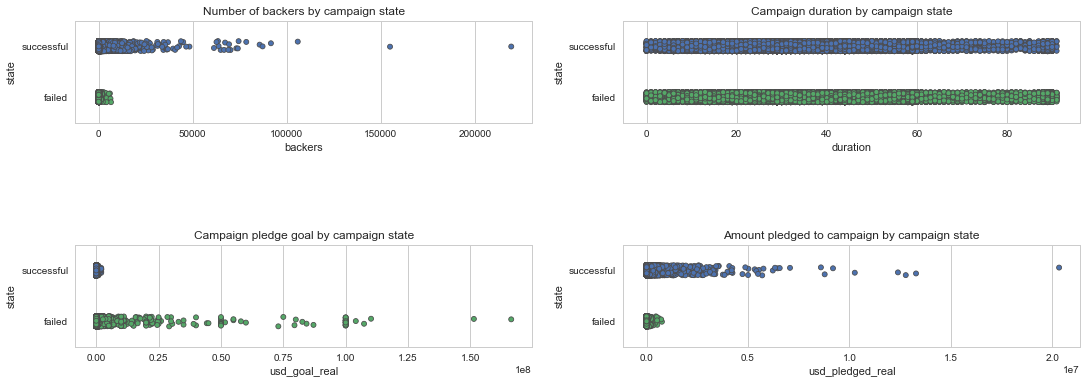

In [8]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,6))

sns.stripplot(x='backers', y='state', data=alldata, jitter=True, linewidth=0.8, ax=ax[0,0])
ax[0,0].set_title('Number of backers by campaign state')
sns.stripplot(x='duration', y='state', data=alldata, jitter=True, linewidth=0.8, ax=ax[0,1])
ax[0,1].set_title('Campaign duration by campaign state')
sns.stripplot(x='usd_goal_real', y='state', data=alldata, jitter=True, linewidth=0.8, ax=ax[1,0])
ax[1,0].set_title('Campaign pledge goal by campaign state')
sns.stripplot(x='usd_pledged_real', y='state', data=alldata, jitter=True, linewidth=0.8, ax=ax[1,1])
ax[1,1].set_title('Amount pledged to campaign by campaign state')

fig.subplots_adjust(hspace=1.2)
fig.show()

Unsuccessful campaigns have a consistently low number of backers and total amount pledged (unlike successful campaigns, which vary widely in this respect). <br>
Conversely, successful campaigns tend to have consistently low campaign pledge goals (unlike unsuccessful campaigns, which vary widely in this respect). <br>
Lastly, campaign duration varies widely for both successful and unsuccessful campaigns. This trend surprised me the most.

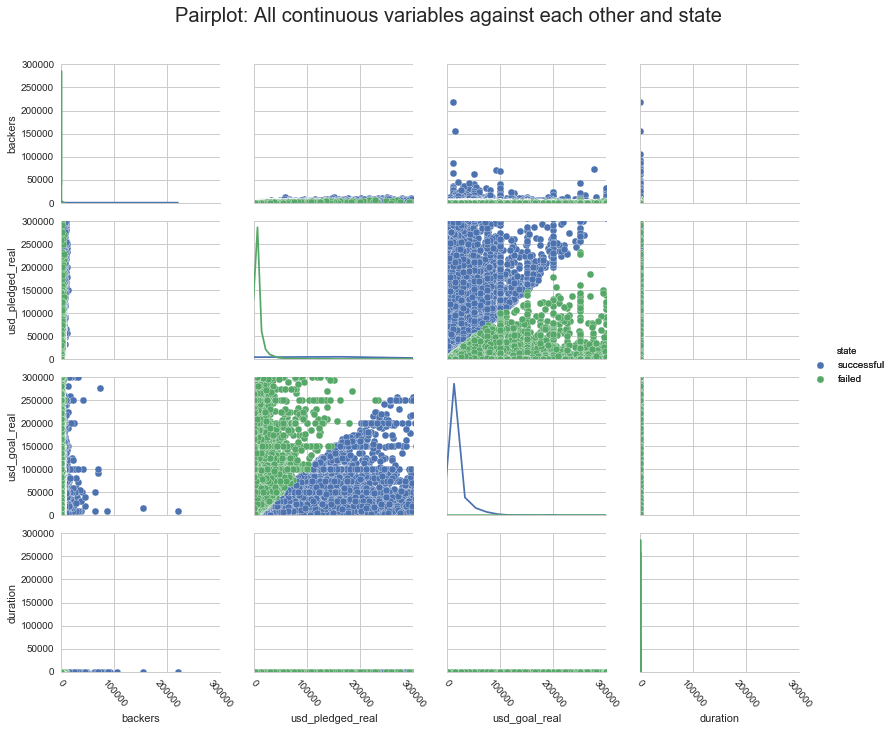

In [9]:
cont_vars = pd.concat([alldata.backers, alldata.usd_pledged_real, alldata.usd_goal_real,
                      alldata.duration, alldata.state], axis=1)
g = sns.pairplot(cont_vars, hue='state', diag_kind='kde')
g.set(xlim=(0,300000), ylim=(0,300000))
g.fig.suptitle('Pairplot: All continuous variables against each other and state', size=20)
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=-50)
g.add_legend()
plt.show()

<b><u>Pair-wise comparisons</u></b><br> I will focus on analzing a few interesting pairwise comparisons:<br>
-  <b>usd_goal_real vs. backers and backers vs. usd_goal_real:</b> successful campaigns have more backers, regardless of the campaign's pledge goal. <br> 
-  <b>backers vs. usd_pledged_real:</b> the number of backers and how much money was pledged to the campaign are not correlated. In other words, a campaign with few people donating large amounts and a campaign with many people donating small amounts can both be successful. <br> 
-  <b>usd_goal_real vs. usd_pledged_real and usd_goal_real vs. usd_pledged_real:</b> in successful campaigns, the campaign goal is met. In unsuccessful campaigns, it is not met. The perfect split with slope=1 between successful and failed campaigns tells us how "success" is defined.

<b><u>Diagonals</u></b><br> The KDE plots confirm the trends we noticed in the previous graphs above.<br> 
-  <b>backers:</b> As seen above, unsuccessful campaigns are likely to have few backers while successful campaigns are likely to have many backers.<br> 
- <b>usd_pledged_real:</b> Successful campaigns are likely to have a wide range of pledged amounts, while unsuccessful campaigns are likely to have very little money pledged to them.<br> 
- <b>usd_goal_real:</b> Successful campaigns are likely to have low funding goals, whereas unsuccessful campaigns are likely to have a range of funding goal.<br> 
-  <b>duration:</b> Like above, there isn't really a discernable pattern when it comes to campaign duration. 

#### Visualizing the categorical variables (country and main_category) against state

C:\Users\Sharon\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


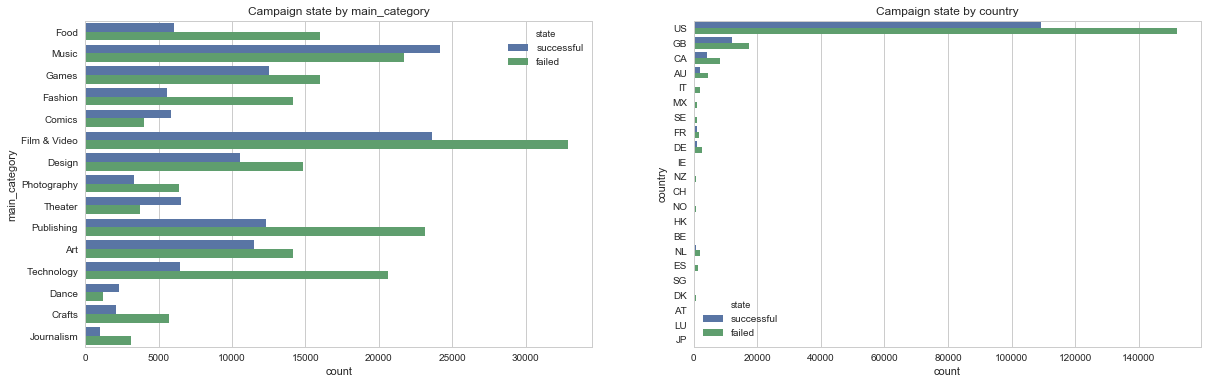

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

sns.countplot(y="main_category", hue="state", data=alldata, ax=ax[0])
ax[0].set_title('Campaign state by main_category')

sns.countplot(y="country", hue="state", data=alldata, ax=ax[1])
ax[1].set_title('Campaign state by country')

fig.show()

<b>Are any categories or countries particularly successful or unsuccessful? </b><br> 
-  The number of successful and unsuccessful campaigns varies most in <i>food</i>, <i>fashion</i>, <i>film and video</i>, <i>publishing</i>, and <i>technology</i>. There are significantly more failed campaigns than successful campaigns in these categories. The only categories with more successful campaigns than failed ones are <i>music</i>, <i>comics</i>, <i>theater</i>, and <i>dance</i>. I would guess this has to do with Kickstarter's audience and the resulting culture around Kickstarter.<br>
-  The number of successful and failed campaigns in each country seems to be fairly proportional. However, it's interesting to note that Italy, Germany, the Netherlands, and Spain appear to have particularly high numbers of unsuccessful campaigns.

#### Visualizing the continuous variables with the categorical variables and state

C:\Users\Sharon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Sharon\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


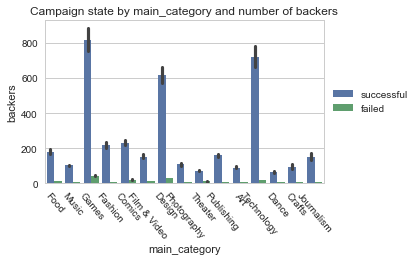

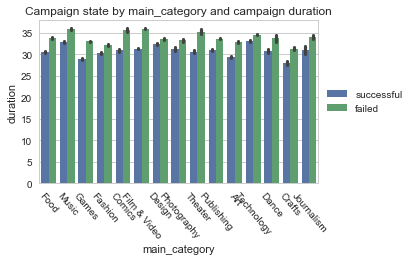

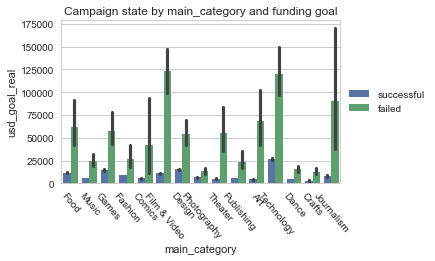

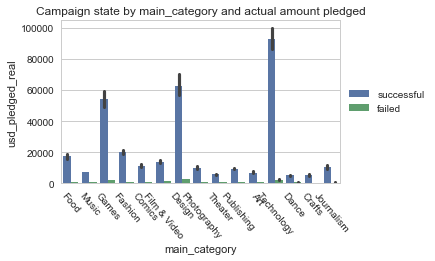

In [11]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='main_category', y='backers', hue='state', data=alldata)
ax.set_title('Campaign state by main_category and number of backers', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='main_category', y='duration', hue='state', data=alldata)
ax.set_title('Campaign state by main_category and campaign duration', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='main_category', y='usd_goal_real', hue='state', data=alldata)
ax.set_title('Campaign state by main_category and funding goal', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='main_category', y='usd_pledged_real', hue='state', data=alldata)
ax.set_title('Campaign state by main_category and actual amount pledged', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.show()

C:\Users\Sharon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Sharon\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


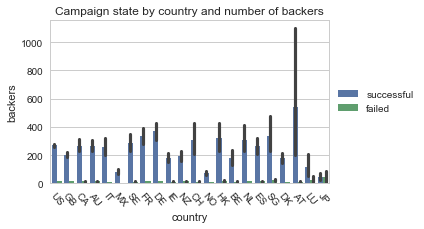

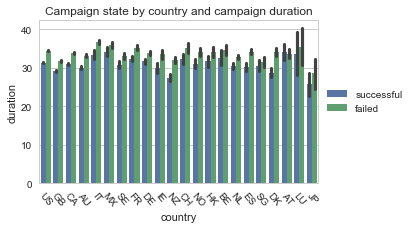

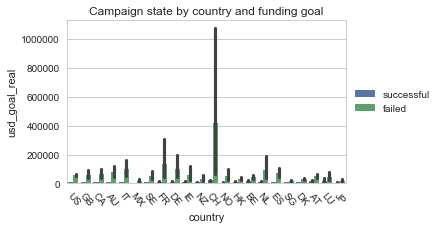

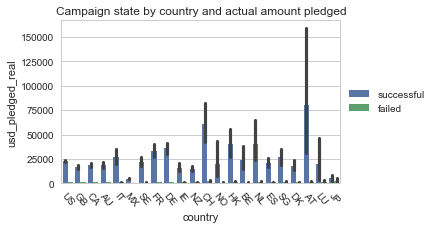

In [12]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='country', y='backers', hue='state', data=alldata)
ax.set_title('Campaign state by country and number of backers', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='country', y='duration', hue='state', data=alldata)
ax.set_title('Campaign state by country and campaign duration', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='country', y='usd_goal_real', hue='state', data=alldata)
ax.set_title('Campaign state by country and funding goal', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x='country', y='usd_pledged_real', hue='state', data=alldata)
ax.set_title('Campaign state by country and actual amount pledged', size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-50)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.show()

The goal of these two visualizations is to understand the way category and country play into campaign success for each continuous variable, separately. The trends in <i>backers</i>, <i>usd_goal_real</i>, <i>usd_pledged_real</i> that we saw above. From the <i>duration</i> graph, we see that unsuccessful campaigns tend to have slightly longer durations across all categories.

## ML Model
#### ML Model - Algorithm choice
I will proceed with Random Forest classification. Its accuracy and power are hard to beat, and it has a fairly simple implementation. 

#### ML Model - Creating and implementing the model

In [13]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score

C:\Users\Sharon\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Sharon\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
# Create a function to make and fit a classifier, predict y_values, and build some accuracy metrics 

def RandomForest(randomState, X_train, X_test, y_train, y_test):
    global classifier
    global cm
    # Creation and fit
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    
    # Prediction
    y_pred = classifier.predict(X_test)
    
    # Important metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)

In [15]:
# Creating dummy variables for categories - one-hot encoding
alldata_enc = pd.get_dummies(alldata, columns=['state', 'main_category', 'country'])
alldata_enc.head()

# Extracting column names for tree visualization later
cols = list(alldata_enc.columns)
cols.remove('state_failed')
cols.remove('state_successful')

In [16]:
#Create a training set and a test set 
X = alldata_enc.drop(['state_successful', 'state_failed'], axis='columns').values
y = alldata_enc.state_successful.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
# Initialize sklearn's built-in scorer
scorer = make_scorer(accuracy_score)

_This is where the magic happens!_

In [18]:
RandomForest(0, X_train, X_test, y_train, y_test)

0.9925831009271124


In [19]:
# 10-fold cross-validation of results
crossvalidation = np.mean(cross_val_score(classifier, X, y, cv=10))
print(np.mean(crossvalidation))

0.9944855610963869


## Conclusion
#### Conclusion - interpreting and visualizing the results of our random forest 

In [20]:
import graphviz
import itertools
from sklearn import tree

#### Decision Tree

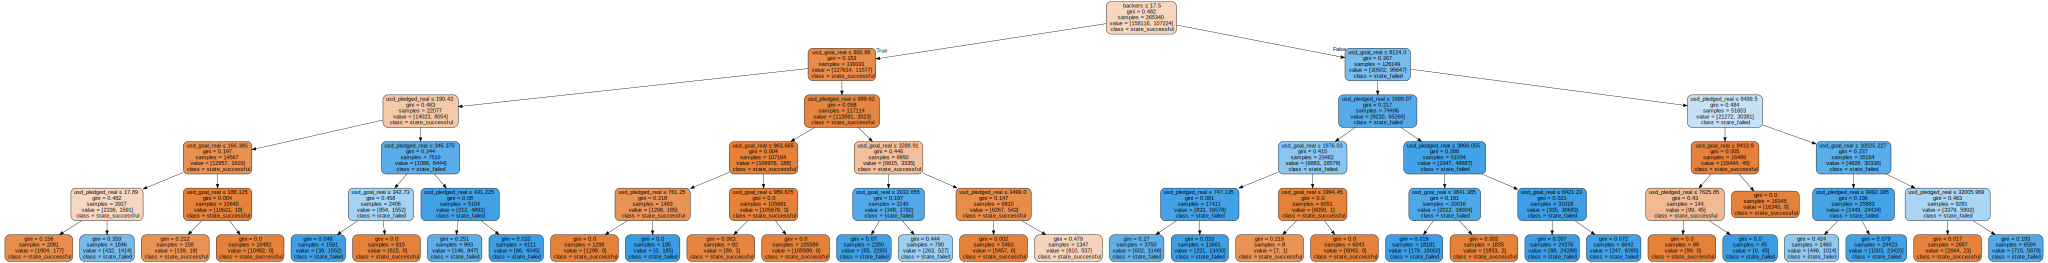

In [21]:
# Visualizing one decision tree
estimator = classifier.estimators_[5]
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('tree')

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=cols,
                                class_names=['state_successful', 'state_failed'],
                                filled=True, rounded=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Understanding the output of the tree diagram: <br>
-  According to GINI, an impurity metric intended to minimize misclassification in binary classifiers, we start (in this tree) with <i>backers</i>. This means the GINI coefficient found <i>backers</i> to be a good feature by which to split the data initially. I would guess that this means <i>backers</i> is an important feature in determining the success or failure of a campaign. We will look at feature importances later to confirm this. <br>
-  Each node tells us how data in the next node should be split (GINI), the number of samples that remain unclassified, guesses for classification of those samples, and the classification of the samples at that node.
-  The decision tree stops when a bin has less than 20 samples or GINI=0.0000 (i.e. the bin contains only one class, there are no impurities). 

#### Confusion Matrix

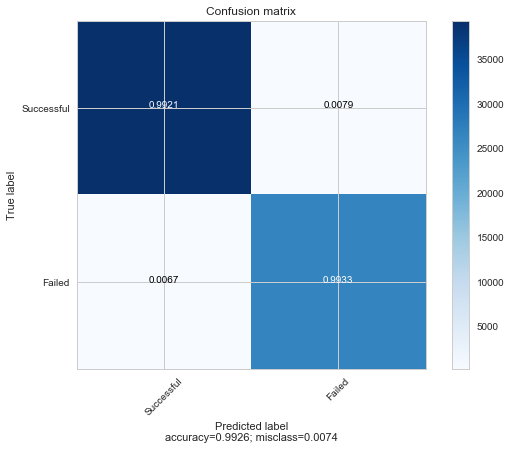

Confusion matrix (values): 
[[39291   312]
 [  180 26552]]


In [22]:
# Plotting the confusion matrix 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm, target_names=['Successful', 'Failed'], title='Confusion matrix', cmap=None, normalize=True)
print('Confusion matrix (values): ')
print(cm)

Our classifier correctly predicts successful campaigns 99.4% of the time, and correctly predicts unsuccessful campaigns 99.7% on this run. Cross-validation (above) confirms that this result represents the classifier's performance well. <br>
Given the context of the problem, predicting success and getting failure (i.e. a false positive) is harmful, whereas the opposite (predicting failure and getting success, a false negative) isn't. Therefore, precision is the best metric to measure the performance of our model. <br>
Precision = true positives/total predicted positives = 39204/39290 = 0.9987, or 99.87% precision. <br>
This is good, I am happy with the performance of this model.

#### Feature importances

In [23]:
# Extracting feature importances
feature_importances = classifier.feature_importances_

feature_importances_df = pd.DataFrame(feature_importances, 
                                   index= alldata_enc.drop(['state_successful', 'state_failed'], axis='columns').columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

keyfeatures_df = feature_importances_df[:4]
keyfeaturenames = np.array(keyfeatures_df.index)
print(keyfeatures_df)

                  importance
backers             0.376738
usd_pledged_real    0.355973
usd_goal_real       0.213401
duration            0.021772


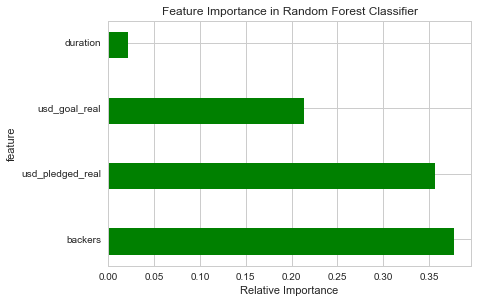

In [24]:
# Plotting feature importances
y = classifier.feature_importances_[:4]
cols=keyfeaturenames

fig, ax = plt.subplots() 

width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups

ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(cols, minor=False)
plt.title('Feature Importance in Random Forest Classifier')
plt.xlabel('Relative Importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

I extracted the most important features by using a built-in method that permutes each column of data and measures the resulting increase an error. Features with higher importance cause a greater increase in error (i.e. removing them does the most damage to the algorithm's success). The results of the key feature extraction align with what I would guess, for the most part. Based on the visualizations above, it makes sense that the most important features in predicting the success of a Kickstarter campaign are the amount of money pledged to it and the number of backers, and that funding goal is close behind. I was most surprised by duration's importance because no clear pattern was evident when visualizing the data earlier. 

## Future Work

I think this dataset would perform well with a neural network. Although the Random Forest Classifier achieves very good results already, it would be interesting to compare its results with those of a neural network. I also think it would be interesting to investigate more thoroughly the launch and deadline dates of this dataset. Do campaigns perform significantly better/worse around a certain time of year? For example, how does the holiday season affect the success of Kickstarter campaigns?

## Sources 

https://github.com/mkucz95/kickstarter_data/blob/master/kickstarter_data.ipynb

https://github.com/bodealamu/Prediction-of-success-in-a-kickstarter-campaign/blob/master/kickstarter%20project.ipynb

https://github.com/gagejustins/Kickstarter/blob/master/kickstarter.ipynb

https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

https://medium.com/@garg.mohit851/random-forest-visualization-3f76cdf6456f

https://scikit-learn.org/stable/modules/tree.html

https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785

https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e

https://www.udemy.com/machinelearning/learn/v4/content
